# Clustering Report for Sporting Cristal

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Functions

In [14]:
#############################################################################################
''' DEFINING NUMBER OF CLUSTERS + GENERATION '''
#############################################################################################

def clusters(num_clusters):
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_model.fit(df_scaled)
    labels = kmeans_model.labels_

    print(f'\n Inertia Score: {kmeans_model.inertia_} \n')

    plt.scatter(df_first['Talla'], df_first['Edad'], c=labels, cmap='viridis')
    plt.xlabel('Talla')
    plt.ylabel('Edad')
    plt.title('Clustering Results')
    plt.show()
    
    df_first['Cluster'] = kmeans_model.fit_predict(df_scaled)
    
    return df_first

#############################################################################################
''' DEFINING NUMBER OF CLUSTERS + GENERATION (Without Standardization) '''
#############################################################################################


def clusters_(num_clusters):
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_model.fit(df_first_X)
    labels = kmeans_model.labels_

    print(f'\n Inertia Score: {kmeans_model.inertia_} \n')

    plt.scatter(df_first['Talla'], df_first['Edad'], c=labels, cmap='viridis')
    plt.xlabel('Talla')
    plt.ylabel('Edad')
    plt.title('Clustering Results')
    plt.show()
    
    df_first['Cluster'] = kmeans_model.fit_predict(df_first_X)
    
    return df_first



#############################################################################################
''' GENERATING STAT RANGES/INTERVALS FUNCTION '''
#############################################################################################

def cluster_stats(df):
    # calculate descriptive statistics for each cluster
    cluster_stats = df.groupby('Cluster')[['Edad', 'Talla']].describe()
    return cluster_stats[[('Edad', 'min'), ('Edad', 'max'),
                      ('Talla', 'min'), ('Talla', 'max')]]



#############################################################################################
''' Function generating final list by only target variables - REVISED VERSION WORKS BETTER'''
#############################################################################################


def new_reference_values_list(df):
    
    # variables of interest
    variables = ['ID', 'MA_Kg','MM_Kg', 'Sum6Pliegues', 'Cluster']
    df = df[variables]
    interest_variables = ['MA_Kg','MM_Kg', 'Sum6Pliegues']
    
    # separate values into clusters
    # convert it into a dictionary
    cluster_datasets = {cluster: group for cluster, group in df.groupby('Cluster')}
    
    
    def reference_values(df, variable):

        # using interquartile ranges as reference values
        quartiles = df[variable].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])

        # defining the ranges basde on quartiles
        range_0_20 = (quartiles.iloc[0], quartiles.iloc[1])
        range_20_40 = (quartiles.iloc[1], quartiles.iloc[2])
        range_40_60 = (quartiles.iloc[2], quartiles.iloc[3])
        range_60_80 = (quartiles.iloc[3], quartiles.iloc[4])
        range_80_100 = (quartiles.iloc[4], quartiles.iloc[5])

        # function creation for string creation
        def classify_group(value):
            if value <= range_0_20[1]: # we use 1 as index to get the highest of the range
                return '0-20'
            elif value <= range_20_40[1]:
                return '20-40'
            elif value <= range_40_60[1]:
                return '40-60'
            elif value <= range_60_80[1]:
                return '60-80'
            else: 
                return '80-100'

        # applying the function to create new column with the group classification
        if variable == 'MM_Kg':
            df['MM_Kg - Grouping'] = df['MM_Kg'].apply(classify_group)
        elif variable == 'MA_Kg':
            df['MA_Kg - Grouping'] = df['MA_Kg'].apply(classify_group)
        elif variable == 'Sum6Pliegues':
            df['SumPliegues - Grouping'] = df['Sum6Pliegues'].apply(classify_group)

        return df
    
    final_list = []        
    
    for key in cluster_datasets:
        for var in interest_variables:
            a = reference_values(cluster_datasets[key], var)
            final_list.append(a)
    
    final_df = pd.concat(final_list, ignore_index=True)
    
    return final_df # here it should be a 'final_df'



#############################################################################################
''' REVISED: Function generating final dataframe by only target variables '''
#############################################################################################

def new_reference_values(df):
    
    # variables of interest
    interest_variables = ['MA_Kg','MM_Kg', 'Sum6Pliegues']
    
    # separate values into clusters
    cluster_datasets = {cluster: group for cluster, group in df.groupby('Cluster')}
    
    def classify_group(value, ranges):
        for i, r in enumerate(ranges):
            if value <= r[1]:
                return f'{i * 20}-{(i + 1) * 20}'
        return '80-100'
    
    final_dfs = []  
    
    for key in cluster_datasets:
        cluster_df = cluster_datasets[key].copy()  # creating copy to avoid modifying the original DataFrame
        for var in interest_variables:
            # calculating reference values
            quartiles = cluster_df[var].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
            ranges = [(quartiles.iloc[i], quartiles.iloc[i+1]) for i in range(5)]
            
            # apply classification function
            cluster_df[f'{var} - Grouping'] = cluster_df[var].apply(lambda x: classify_group(x, ranges))
        
        final_dfs.append(cluster_df)
    
    final_df = pd.concat(final_dfs)  # Concatenate all DataFrames into a single DataFrame
    
    return final_df



## Data Exploration & Cleaning 
### Selecting first records for each player

In [3]:
df = pd.read_csv('dataset_antropometria.csv')
df.head(3)

# sort records by ID and date
df.sort_values(by=['ID', 'Fecha'], inplace=True)
df.reset_index()

# keep first observation for each player
df_first = df.groupby('ID').first().reset_index()
df_first.head(3)

df_first.describe()

#investigate the 90 cm tall player
df_first[df_first['Talla'] ==90.8]

df_first.drop([158], inplace = True)

df_first.describe()

# we'll delete this record as it is an outlier and the k-means clustering is sensitive to them
# additionally, having a 18 year old player with an Height of 90.8 doesn't make sense.

,ID,Correlativo,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,MO_kg,MM_Per,...,MusloMedio,Pierna,Triceps,Subescapular,Supraespinal,Abdominal,Muslo,Pantorrilla,Nro_Evaluacion,MG_Per
count,2.400000e+02,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,...,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,161.000000
mean,1.000014e+07,328.56250,15.062083,169.560000,16.804468,61.132500,24.098770,14.633534,7.906172,45.534931,...,50.20875,34.780833,7.841667,8.127917,8.155417,10.556667,8.465417,6.291250,1.212500,14.280186
std,8.504996e+01,344.51593,1.866782,9.589738,8.130153,10.274831,3.253549,2.706169,1.350530,3.860103,...,4.53514,2.860547,2.179789,2.571182,2.039149,4.073329,2.623089,2.258903,1.078823,3.145205
min,1.000000e+07,1.00000,11.600000,139.400000,1.957200,31.300000,17.010000,8.482000,4.879000,33.380000,...,26.80000,25.700000,4.000000,4.200000,4.000000,2.500000,2.000000,2.000000,1.000000,9.810000
25%,1.000007e+07,60.75000,13.500000,164.175000,16.152966,54.675000,21.708811,12.880378,7.221722,43.099856,...,47.50000,33.100000,6.600000,7.000000,6.800000,7.800000,6.900000,4.600000,1.000000,12.150000
50%,1.000014e+07,120.50000,14.900000,170.050000,20.499753,62.350000,23.585885,14.471790,7.982000,45.502803,...,50.50000,34.850000,7.500000,7.900000,8.400000,9.700000,8.200000,5.700000,1.000000,13.580000
75%,1.000020e+07,573.25000,16.500000,175.425000,22.092821,68.200000,25.956114,16.153250,8.651187,47.780925,...,53.02500,36.525000,8.800000,9.000000,9.325000,12.650000,9.650000,7.700000,1.000000,15.750000
max,1.000030e+07,1013.00000,20.700000,192.800000,26.661794,88.900000,39.210287,22.605370,17.386720,55.320000,...,62.20000,53.000000,21.400000,38.100000,16.400000,31.200000,21.100000,15.100000,9.000000,30.100000


## Clusters 4,5,6 - (0.5) Weighted K-means Clusters

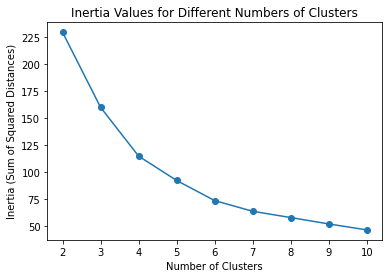

In [5]:
# keeping a dataframe only with the interested features
df_first_X = df_first[['Edad', 'Talla']]
df_first_X.head()

### Visualizing Inertia Scores ####

# Standardize the features. Featuring Scaling method where values are centered around the mean with a unit standard deviation

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_first_X)

# setting a range of cluster values to iterate over and see inertia scores for each
cluster_range = range(2,11) 

inertia_values = []

for num_clusters in cluster_range:
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_model.fit(df_scaled)
    inertia_values.append(kmeans_model.inertia_)
    
# visualizing inertia graph
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Inertia Values for Different Numbers of Clusters')
plt.show()

### 4 Clusters


 Inertia Score: 115.0527056187513 



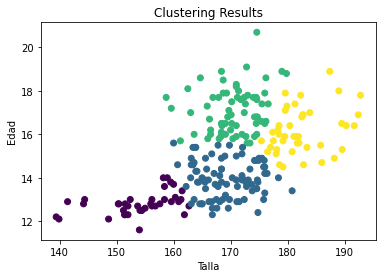

Edad        Talla       
          min   max    min    max
Cluster                          
0        11.6  14.0  139.4  162.7
1        12.3  15.6  160.0  180.8
2        15.6  20.7  158.7  179.8
3        14.5  18.9  175.4  192.8

In [18]:
four_clusters = clusters(4)
cluster_stats(four_clusters)

In [12]:
new_df_four_clusters = new_reference_values(four_clusters)
new_df_four_clusters.head()

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per,Cluster,MA_Kg - Grouping,MM_Kg - Grouping,Sum6Pliegues - Grouping
2,10000003,87,2023-01-12,Sub-15,14.6,163.4,17.041479,45.5,23.064055,10.494145,...,2.5,5.4,3.5,2023-10-19 19:58:19.247,1,NaN,0,0-20,0-20,0-20
3,10000004,243,2023-03-09,Sub-15,14.4,168.4,20.417116,57.9,23.057377,13.350222,...,9.6,9.2,5.9,2023-10-19 19:58:19.247,1,NaN,0,40-60,80-100,40-60
4,10000005,88,2023-01-12,Sub-15,14.1,168.1,20.030003,56.6,26.300509,14.886088,...,11.0,8.4,7.7,2023-10-19 19:58:19.247,1,12.79,0,60-80,20-40,60-80
5,10000006,456,2023-07-11,Sub-13,13.4,161.5,19.361827,50.5,26.290000,13.277000,...,11.8,8.2,7.4,2023-10-19 19:58:19.247,1,17.65,0,40-60,20-40,60-80
6,10000008,917,2024-01-22,Sub-13,13.0,161.3,2.601800,52.3,23.990000,12.548000,...,11.8,8.2,6.0,2024-01-27 20:03:20.700,1,14.98,0,20-40,40-60,60-80


### 5 Clusters


 Inertia Score: 92.50568028967174 



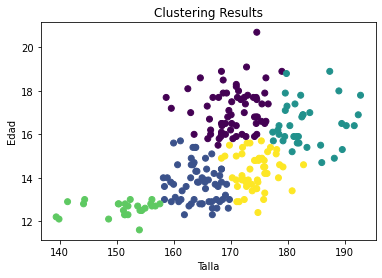

Edad        Talla       
          min   max    min    max
Cluster                          
0        15.5  20.7  158.7  179.0
1        12.3  15.7  158.2  169.8
2        14.7  18.9  177.4  192.8
3        11.6  13.0  139.4  157.6
4        12.4  15.7  168.4  182.8

In [7]:
five_clusters = clusters(5)
cluster_stats(five_clusters)

In [13]:
new_df_five_clusters = new_reference_values(five_clusters)
new_df_five_clusters.head()

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per,Cluster,MA_Kg - Grouping,MM_Kg - Grouping,Sum6Pliegues - Grouping
2,10000003,87,2023-01-12,Sub-15,14.6,163.4,17.041479,45.5,23.064055,10.494145,...,2.5,5.4,3.5,2023-10-19 19:58:19.247,1,NaN,0,0-20,0-20,0-20
3,10000004,243,2023-03-09,Sub-15,14.4,168.4,20.417116,57.9,23.057377,13.350222,...,9.6,9.2,5.9,2023-10-19 19:58:19.247,1,NaN,0,40-60,80-100,40-60
4,10000005,88,2023-01-12,Sub-15,14.1,168.1,20.030003,56.6,26.300509,14.886088,...,11.0,8.4,7.7,2023-10-19 19:58:19.247,1,12.79,0,60-80,20-40,60-80
5,10000006,456,2023-07-11,Sub-13,13.4,161.5,19.361827,50.5,26.290000,13.277000,...,11.8,8.2,7.4,2023-10-19 19:58:19.247,1,17.65,0,40-60,20-40,60-80
6,10000008,917,2024-01-22,Sub-13,13.0,161.3,2.601800,52.3,23.990000,12.548000,...,11.8,8.2,6.0,2024-01-27 20:03:20.700,1,14.98,0,20-40,40-60,60-80


### 6 Clusters


 Inertia Score: 73.85500443193273 



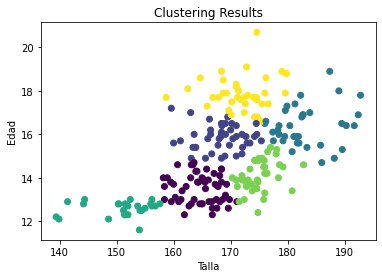

Edad        Talla       
          min   max    min    max
Cluster                          
0        12.3  14.7  158.2  171.1
1        14.9  17.2  159.6  175.4
2        14.7  18.9  176.0  192.8
3        11.6  13.0  139.4  157.6
4        12.4  15.4  170.3  182.8
5        16.6  20.7  158.7  179.8

In [8]:
six_clusters = clusters(6)
cluster_stats(six_clusters)

In [9]:
new_df_six_clusters = new_reference_values(six_clusters)
new_df_six_clusters.head()

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per,Cluster,MA_Kg - Grouping,MM_Kg - Grouping,Sum6Pliegues - Grouping
2,10000003,87,2023-01-12,Sub-15,14.6,163.4,17.041479,45.5,23.064055,10.494145,...,2.5,5.4,3.5,2023-10-19 19:58:19.247,1,NaN,0,0-20,0-20,0-20
3,10000004,243,2023-03-09,Sub-15,14.4,168.4,20.417116,57.9,23.057377,13.350222,...,9.6,9.2,5.9,2023-10-19 19:58:19.247,1,NaN,0,40-60,80-100,40-60
4,10000005,88,2023-01-12,Sub-15,14.1,168.1,20.030003,56.6,26.300509,14.886088,...,11.0,8.4,7.7,2023-10-19 19:58:19.247,1,12.79,0,60-80,20-40,60-80
5,10000006,456,2023-07-11,Sub-13,13.4,161.5,19.361827,50.5,26.290000,13.277000,...,11.8,8.2,7.4,2023-10-19 19:58:19.247,1,17.65,0,40-60,20-40,60-80
6,10000008,917,2024-01-22,Sub-13,13.0,161.3,2.601800,52.3,23.990000,12.548000,...,11.8,8.2,6.0,2024-01-27 20:03:20.700,1,14.98,0,20-40,40-60,60-80


## Clusters 4,5,6 - Height Based - No Standardization

### 4 Clusters


 Inertia Score: 3295.9259052843713 



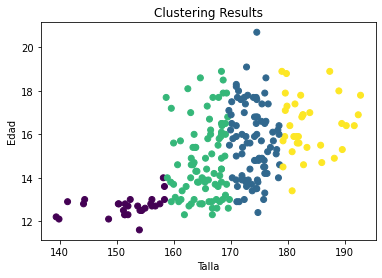

Edad        Talla       
          min   max    min    max
Cluster                          
0        11.6  14.0  139.4  158.4
1        12.4  20.7  169.7  178.6
2        12.3  18.9  158.7  169.8
3        13.4  18.9  179.0  192.8

In [17]:
four_clusters_ = clusters_(4)
cluster_stats(four_clusters_)

In [21]:
new_df_four_clusters_ = new_reference_values(four_clusters_)
new_df_four_clusters_.head()

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per,Cluster,MA_Kg - Grouping,MM_Kg - Grouping,Sum6Pliegues - Grouping
3,10000004,243,2023-03-09,Sub-15,14.4,168.4,20.417116,57.9,23.057377,13.350222,...,9.6,9.2,5.9,2023-10-19 19:58:19.247,1,NaN,0,20-40,20-40,40-60
4,10000005,88,2023-01-12,Sub-15,14.1,168.1,20.030003,56.6,26.300509,14.886088,...,11.0,8.4,7.7,2023-10-19 19:58:19.247,1,12.79,0,60-80,0-20,60-80
9,10000013,226,2023-03-08,Sub-14,14.2,167.1,20.736032,57.9,24.603933,14.245677,...,8.6,9.2,6.9,2023-10-19 19:58:19.247,1,30.10,0,40-60,20-40,40-60
14,10000018,782,2023-01-06,Reserva,18.6,164.7,2.712600,58.2,19.970000,11.626000,...,9.0,9.0,3.5,2024-01-27 20:03:20.700,9,11.48,0,0-20,60-80,0-20
16,10000020,1008,2023-03-04,Sub-16,14.4,165.8,2.749000,54.1,20.690000,11.191000,...,9.0,7.0,4.0,2024-01-27 20:03:20.700,1,12.07,0,0-20,20-40,0-20


### 5 Clusters


 Inertia Score: 2428.2542860770855 



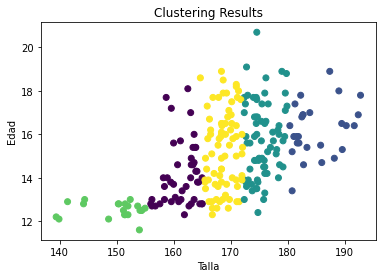

Edad        Talla       
          min   max    min    max
Cluster                          
0        12.3  18.1  156.0  165.0
1        13.4  18.9  180.4  192.8
2        12.4  20.7  172.4  179.9
3        11.6  13.0  139.4  155.0
4        12.3  18.9  164.7  172.1

In [19]:
five_clusters_ = clusters_(5)
cluster_stats(five_clusters_)

In [22]:
new_df_five_clusters_ = new_reference_values(five_clusters_)
new_df_five_clusters_.head()

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per,Cluster,MA_Kg - Grouping,MM_Kg - Grouping,Sum6Pliegues - Grouping
3,10000004,243,2023-03-09,Sub-15,14.4,168.4,20.417116,57.9,23.057377,13.350222,...,9.6,9.2,5.9,2023-10-19 19:58:19.247,1,NaN,0,20-40,20-40,40-60
4,10000005,88,2023-01-12,Sub-15,14.1,168.1,20.030003,56.6,26.300509,14.886088,...,11.0,8.4,7.7,2023-10-19 19:58:19.247,1,12.79,0,60-80,0-20,60-80
9,10000013,226,2023-03-08,Sub-14,14.2,167.1,20.736032,57.9,24.603933,14.245677,...,8.6,9.2,6.9,2023-10-19 19:58:19.247,1,30.10,0,40-60,20-40,40-60
14,10000018,782,2023-01-06,Reserva,18.6,164.7,2.712600,58.2,19.970000,11.626000,...,9.0,9.0,3.5,2024-01-27 20:03:20.700,9,11.48,0,0-20,60-80,0-20
16,10000020,1008,2023-03-04,Sub-16,14.4,165.8,2.749000,54.1,20.690000,11.191000,...,9.0,7.0,4.0,2024-01-27 20:03:20.700,1,12.07,0,0-20,20-40,0-20


### 6 Clusters


 Inertia Score: 1892.5200093418184 



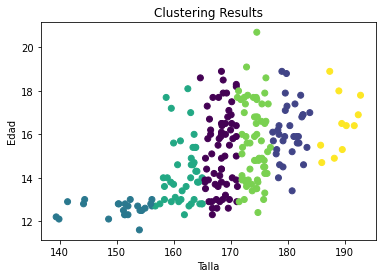

Edad        Talla       
          min   max    min    max
Cluster                          
0        12.3  18.9  164.7  171.2
1        13.4  18.9  177.4  183.9
2        11.6  13.0  139.4  156.2
3        12.3  18.1  156.8  165.0
4        12.4  20.7  171.2  177.0
5        14.7  18.9  185.8  192.8

In [20]:
six_clusters_ = clusters_(6)
cluster_stats(six_clusters_)

In [23]:
new_df_six_clusters_ = new_reference_values(six_clusters_)
new_df_six_clusters_.head()

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per,Cluster,MA_Kg - Grouping,MM_Kg - Grouping,Sum6Pliegues - Grouping
3,10000004,243,2023-03-09,Sub-15,14.4,168.4,20.417116,57.9,23.057377,13.350222,...,9.6,9.2,5.9,2023-10-19 19:58:19.247,1,NaN,0,20-40,20-40,40-60
4,10000005,88,2023-01-12,Sub-15,14.1,168.1,20.030003,56.6,26.300509,14.886088,...,11.0,8.4,7.7,2023-10-19 19:58:19.247,1,12.79,0,60-80,0-20,60-80
9,10000013,226,2023-03-08,Sub-14,14.2,167.1,20.736032,57.9,24.603933,14.245677,...,8.6,9.2,6.9,2023-10-19 19:58:19.247,1,30.10,0,40-60,20-40,40-60
14,10000018,782,2023-01-06,Reserva,18.6,164.7,2.712600,58.2,19.970000,11.626000,...,9.0,9.0,3.5,2024-01-27 20:03:20.700,9,11.48,0,0-20,60-80,0-20
16,10000020,1008,2023-03-04,Sub-16,14.4,165.8,2.749000,54.1,20.690000,11.191000,...,9.0,7.0,4.0,2024-01-27 20:03:20.700,1,12.07,0,0-20,20-40,0-20
